# Explore Data: Session 4

April 3, 2022

* Process json --> numpy
* Visualize trace
* PCA
* SVM

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

import bisect
import random

from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

In [2]:
meta_data_path = "meta_session_4.tsv"
jsons_base_path = "raw_data_session_4/"
FIG_SIZE = (10, 7)
random.seed(42)

## Load Meta Data

In [3]:
# load meta_data
meta_data = pd.read_csv(meta_data_path, sep="\t", header=1)
meta_data["trial"] = meta_data.index
meta_data

,date,subject,replicate,noise-level,intent,body orientation,ring,hand,hand rest (stability),hand orientation,gestures,firebase,time,X_trial,X_num_taps,X_detected_starts,X_extra_starts_in_front,X_extra_starts_in_end,sanity check,trial
0,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",f-d-b-f-d-i-f-f-f-d-f-b-b-b-d-d-i-i-f-d-b-d-b-...,F0442A72-0E6E-4790-AB16-00940C3D37A7.json,1:39:00 PM,0,78 (missed the first one?),42,2,0,40,0
1,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"45 deg (in air, chest-level)",f-f-b-i-f-d-d-b-f-f-b-b-d-d-f-d-d-i-i-d-i-b-i-...,7D3D29CF-4CC6-476C-8515-47A797371DA9.json,1:42:00 PM,1,80,42,2,0,40,1
2,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,"implicitly, for comfort","0 deg (in air, table-level)",d-f-i-i-b-b-d-b-f-f-f-b-f-f-b-d-f-d-b-d-d-i-d-...,619E3C34-63FE-40BA-A413-AF65C26CD0EB.json,1:49:00 PM,2,80,41,1,0,40,2
3,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,"implicitly, for comfort","0 deg (in air, thigh-level)",d-i-b-f-b-f-b-d-b-i-i-f-i-b-b-f-f-f-b-f-d-d-d-...,7A603F4E-26E2-4554-A1E0-DDBB11322975.json,1:53:00 PM,3,80,44,4,0,40,3
4,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,"implicitly, for comfort","-45 deg (in air, chair-level)",b-d-f-i-d-d-b-f-f-b-i-f-d-f-i-b-d-i-f-i-b-b-d-...,4D0D047F-D491-4CB5-8E62-85F6CC5D9FDE.json,1:56:00 PM,4,80,41,1,0,40,4
5,April 2,Gati,1,clean,"small, as discrete as possible (wrist)",sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",f-b-b-d-f-b-d-b-d-i-i-d-b-f-f-d-i-i-d-i-i-b-i-...,C741CE85-2F28-4880-892D-DA1E7253AC2D.json,2:10:00 PM,5,80,43,2,1,40,5
6,April 2,Gati,1,clean,"small, as discrete as possible (wrist)",sitting in chair,"2-finger, pointer-index",right,no,"45 deg (in air, chest-level)",f-d-d-d-i-b-i-d-b-b-d-f-b-b-f-i-i-b-f-f-i-i-i-...,DC5BB718-9479-4129-81EE-D18E3E7F69E4.json,2:12:00 PM,6,80,43,2,1,40,6
7,April 2,Gati,1,clean,"small, as discrete as possible (wrist)",sitting in chair,"2-finger, pointer-index",right,"implicitly, for comfort","0 deg (in air, table-level)",d-d-i-i-d-i-f-d-b-i-i-f-d-f-i-f-b-d-f-b-b-b-i-...,13FC086D-854A-4DA1-9A4D-2314A55F6122.json,2:17:00 PM,7,80,43,3,0,40,7
8,April 2,Gati,1,clean,"small, as discrete as possible (wrist)",sitting in chair,"2-finger, pointer-index",right,"implicitly, for comfort","0 deg (in air, thigh-level)",f-b-d-d-b-f-f-b-d-f-f-d-d-f-i-b-b-i-b-d-b-d-i-...,8912A5AF-3D2A-47DD-81C1-0760A514C8D6.json,2:20:00 PM,8,80,44,3,1,40,8
9,April 2,Gati,1,clean,"small, as discrete as possible (wrist)",sitting in chair,"2-finger, pointer-index",right,"implicitly, for comfort","-45 deg (in air, chair-level)",d-d-d-f-b-i-f-b-i-f-i-b-i-b-b-f-f-b-d-b-f-d-d-...,5BB4F9AC-C8B3-41F7-947C-4C6C8C6C50FA.json,2:22:00 PM,9,80,43,2,1,40,9


In [4]:
all_meta_data_gestures = meta_data.assign(gestures=meta_data.gestures.str.split('-'))
all_meta_data_gestures = all_meta_data_gestures.explode("gestures")
all_meta_data_gestures["gesture_num"] = all_meta_data_gestures["gestures"].map({
    "a": 1, "b": 2, "c": 3, "d": 4, "e": 5,
    "f": 6, "g": 7, "h": 8, "i": 9, "j": 10,
    "k": 11, "l": 12, "m": 13, "n": 14})
all_meta_data_gestures["index"] = range(len(all_meta_data_gestures))
all_meta_data_gestures = all_meta_data_gestures.set_index("index")
all_meta_data_gestures

,date,subject,replicate,noise-level,intent,body orientation,ring,hand,hand rest (stability),hand orientation,...,firebase,time,X_trial,X_num_taps,X_detected_starts,X_extra_starts_in_front,X_extra_starts_in_end,sanity check,trial,gesture_num
index,,,,,,,,,,,,,,,,,,,,,
0,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",...,F0442A72-0E6E-4790-AB16-00940C3D37A7.json,1:39:00 PM,0,78 (missed the first one?),42,2,0,40,0,6
1,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",...,F0442A72-0E6E-4790-AB16-00940C3D37A7.json,1:39:00 PM,0,78 (missed the first one?),42,2,0,40,0,4
2,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",...,F0442A72-0E6E-4790-AB16-00940C3D37A7.json,1:39:00 PM,0,78 (missed the first one?),42,2,0,40,0,2
3,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",...,F0442A72-0E6E-4790-AB16-00940C3D37A7.json,1:39:00 PM,0,78 (missed the first one?),42,2,0,40,0,6
4,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",...,F0442A72-0E6E-4790-AB16-00940C3D37A7.json,1:39:00 PM,0,78 (missed the first one?),42,2,0,40,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,April 2,Gati,1,messy (no taps),walking (wrist/elbow -- as comfortable),walking,"2-finger, pointer-index",right,no,comfortable,...,CC9BAA36-FA41-472D-AAA2-26F82682CFAC.json,3:20:00 PM,16,1,26,4,1,incomplete?,16,9
676,April 2,Gati,1,messy (no taps),walking (wrist/elbow -- as comfortable),walking,"2-finger, pointer-index",right,no,comfortable,...,CC9BAA36-FA41-472D-AAA2-26F82682CFAC.json,3:20:00 PM,16,1,26,4,1,incomplete?,16,4
677,April 2,Gati,1,messy (no taps),walking (wrist/elbow -- as comfortable),walking,"2-finger, pointer-index",right,no,comfortable,...,CC9BAA36-FA41-472D-AAA2-26F82682CFAC.json,3:20:00 PM,16,1,26,4,1,incomplete?,16,6


In [5]:
all_meta_data_gestures["gesture_num"].unique()

array([6, 4, 2, 9])

In [6]:
meta_data["intent"].unique()

array(['isolated (wrist)', 'small, as discrete as possible (wrist)',
       'large, maybe more comfortable (elbow)',
       'walking (wrist/elbow -- as comfortable)'], dtype=object)

In [7]:
def parse_json(entry=0, visualize_trace=False):
    # read 1 json
    json_rel_path = meta_data["firebase"][entry] #.split("/")[1]
    with open(f"{jsons_base_path}{json_rel_path}", "r") as f:
        j = json.loads(f.read())
    
    j_am = np.array(j["attitudes"]["measurements"])
    m_len = j_am.shape[0]
    t_len = len(j["attitudes"]["timestamps"])
    # sometimes 3 extra measurements with no corresponding timestamps
    if (m_len > t_len): 
        j_am = j_am[0:t_len]
    # sometimes vice versa
    if (m_len < t_len): 
        j_am = j_am[0:m_len]
    if (visualize_trace):
        print("j_am.shape", j_am.shape[0])
        print("j timestamps", len(j["attitudes"]["timestamps"]))
    
    j_lam = np.array(j["linearAccelerations"]["measurements"])
    m_len = j_lam.shape[0]
    t_len = len(j["linearAccelerations"]["timestamps"])
    # sometimes 3 extra measurements with no corresponding timestamps
    if (m_len > t_len): 
        j_lam = j_lam[0:t_len]
    # sometimes vice versa
    if (m_len < t_len): 
        j_lam = j_lam[0:m_len]
    
    if (visualize_trace):
        print("j_lam.shape", j_lam.shape[0])
        print("j timestamps", len(j["linearAccelerations"]["timestamps"]))
    

    p_a = pd.DataFrame(
        {"timestamps": j["attitudes"]["timestamps"],
         "a_1": j_am[:, 0],
         "a_2": j_am[:, 1],
         "a_3": j_am[:, 2],
         "a_4": j_am[:, 3]
        }
    )

    p_la = pd.DataFrame(
        {"timestamps": j["linearAccelerations"]["timestamps"],
         "la_x": j_lam[:, 0],
         "la_y": j_lam[:, 1],
         "la_z": j_lam[:, 2]
        }
    )
    
    p_taps = pd.DataFrame(
        {"timestamps": j["taps"]["timestamps"],
         "tap": [0.5] * len(j["taps"]["timestamps"])
        }
    )
    
    ##############################
    # IDENTIFY START OF GESTURES #
    ##############################
    
    # identify high variable regions
    p_la["la_x_m"] = p_la["la_x"].abs().rolling(5).max()
    p_la["la_y_m"] = p_la["la_y"].abs().rolling(5).max()
    p_la["la_z_m"] = p_la["la_z"].abs().rolling(5).max()    
    
    # if linear accelerations are above variance threshold
    # then gesture is happening
    if (meta_data["intent"][entry] == 'small, as discrete as possible (wrist)'):
        thresh_m = 0.05
    else:
        thresh_m = 0.4
    p_la["is_gesture"] = p_la.apply(lambda row:
        ((row["la_x_m"] > thresh_m) + 
        (row["la_y_m"] > thresh_m) + 
        (row["la_z_m"] > thresh_m) >= 1), axis=1)
    
    # get starting point of gesture segment
    ts = []
    last_ts = 0
    for index, row in p_la[p_la["is_gesture"].diff() == 1].iterrows():
        this_ts = row["timestamps"]
        if (this_ts - last_ts > 2): # if greater than 2 second, then new gesture
            ts.append(this_ts)
            last_ts = this_ts
    
    # based on visual observation, remove false starts at front and end of trial 
    X_starts_front = meta_data["X_extra_starts_in_front"][entry]
    X_starts_ends = meta_data["X_extra_starts_in_end"][entry]
    if (X_starts_front):
        ts = ts[X_starts_front:]
    if (X_starts_ends):
        ts = ts[:-X_starts_ends]
    print("starts:", len(ts))
    p_start = pd.DataFrame(
        {"timestamps": ts,
         "start": [1] * len(ts)
        }
    )
    
    if (visualize_trace):
        fig, axs = plt.subplots(2, figsize=FIG_SIZE)
        fig.suptitle(f"Trial {entry} ({len(ts)})")
#         # plot attitudes
#         axs[0].plot(
#             p_a["timestamps"],
#             p_a["a_x"],
#         )
#         axs[0].plot(
#             p_a["timestamps"],
#             p_a["a_y"],
#         )
#         axs[0].plot(
#             p_a["timestamps"],
#             p_a["a_z"],
#         )
        axs[0].scatter(
            p_taps["timestamps"],
            p_taps["tap"],
            c = "blue"
        )
        axs[0].scatter(
            p_start["timestamps"],
            p_start["start"],
            c = "purple"
        )
        
        # plot linear acceleration
        axs[1].plot(
            p_la["timestamps"],
            p_la["la_x"],
        )
        axs[1].plot(
            p_la["timestamps"],
            p_la["la_y"],
        )
        axs[1].plot(
            p_la["timestamps"],
            p_la["la_z"],
        )
#         axs[1].scatter(
#             p_taps["timestamps"],
#             p_taps["tap"],
#         )
        axs[1].scatter(
            p_start["timestamps"],
            p_start["start"],
            c = "purple"
        )
            
    return p_a, p_la, p_start, p_taps

j_am.shape 12088
j timestamps 12088
j_lam.shape 11906
j timestamps 11906
starts: 40
j_am.shape 13097
j timestamps 13097
j_lam.shape 13056
j timestamps 13056
starts: 40
j_am.shape 13205
j timestamps 13205
j_lam.shape 13177
j timestamps 13177
starts: 40
j_am.shape 13402
j timestamps 13402
j_lam.shape 13393
j timestamps 13393
starts: 40
j_am.shape 12940
j timestamps 12940
j_lam.shape 12836
j timestamps 12836
starts: 40
j_am.shape 12128
j timestamps 12128
j_lam.shape 12016
j timestamps 12016
starts: 40
j_am.shape 13179
j timestamps 13179
j_lam.shape 13177
j timestamps 13177
starts: 40
j_am.shape 12926
j timestamps 12926
j_lam.shape 12876
j timestamps 12876
starts: 40
j_am.shape 13181
j timestamps 13181
j_lam.shape 13178
j timestamps 13178
starts: 40
j_am.shape 10444
j timestamps 10444
j_lam.shape 10165
j timestamps 10165
starts: 40
j_am.shape 13846
j timestamps 13846
j_lam.shape 13825
j timestamps 13825
starts: 40
j_am.shape 13480
j timestamps 13480
j_lam.shape 13477
j timestamps 13477
sta

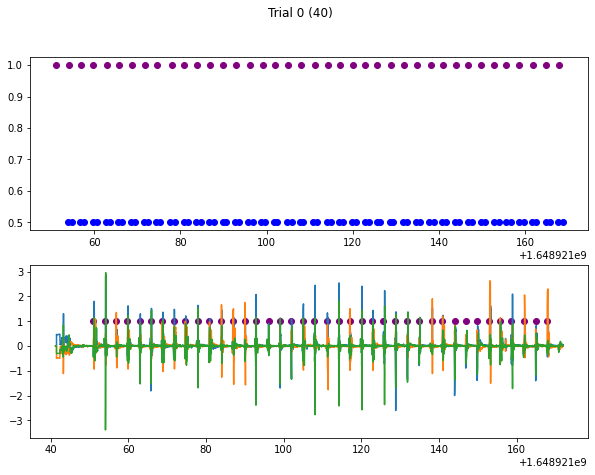

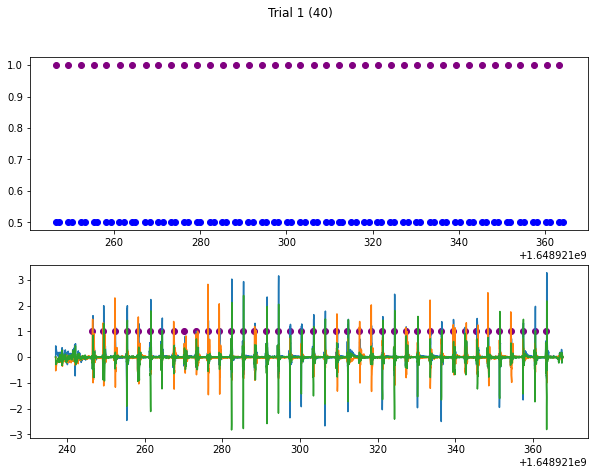

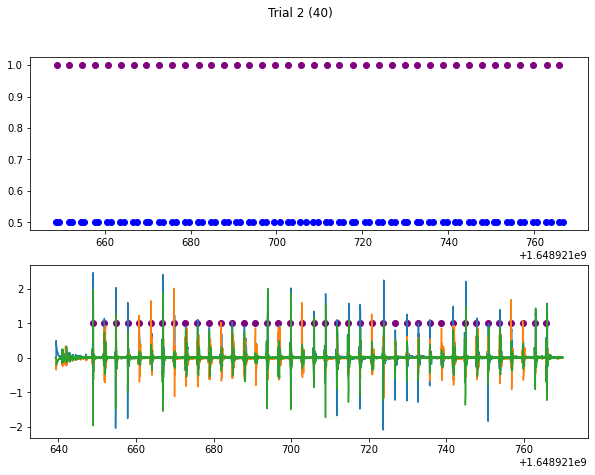

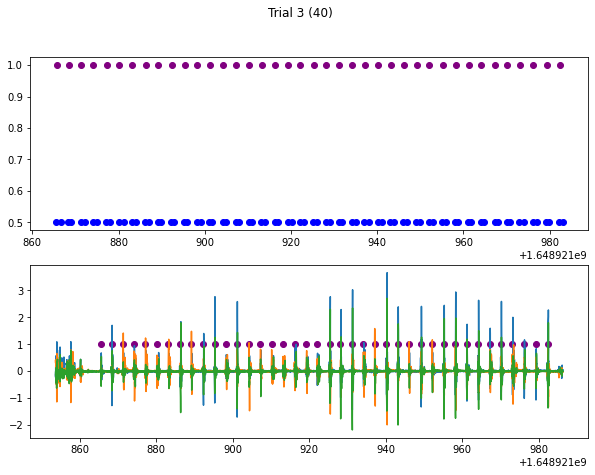

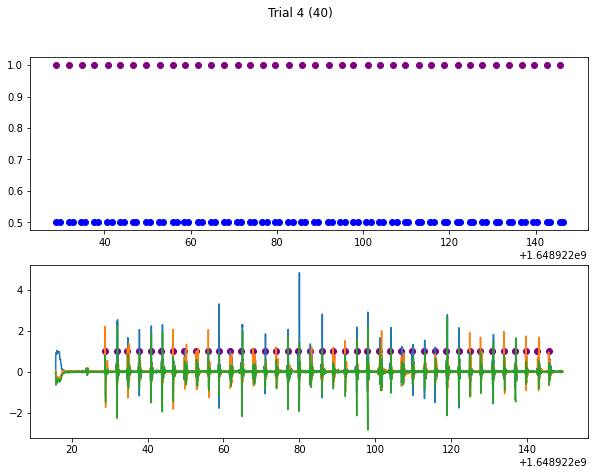

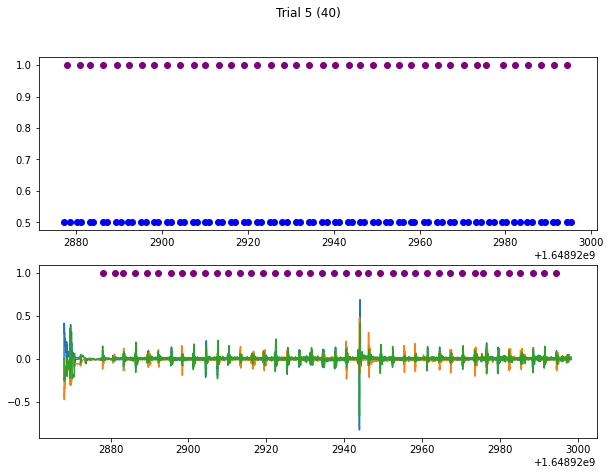

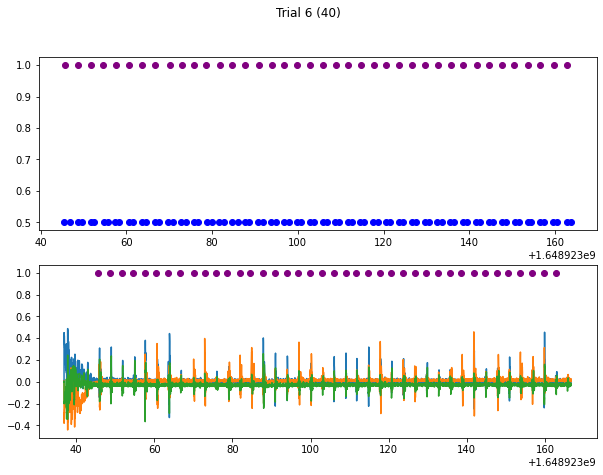

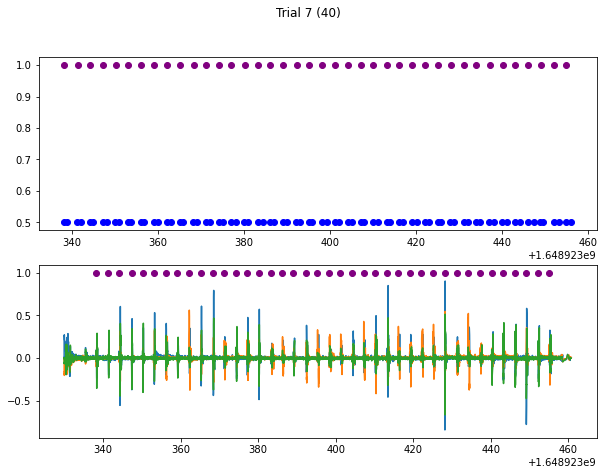

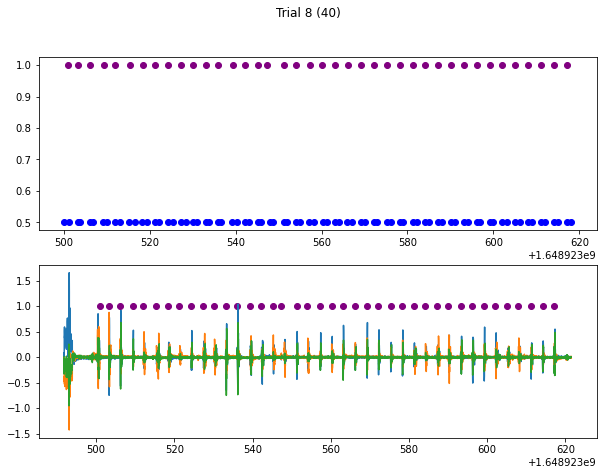

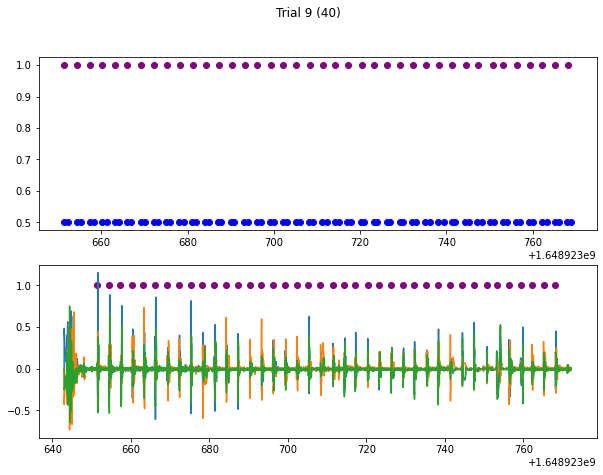

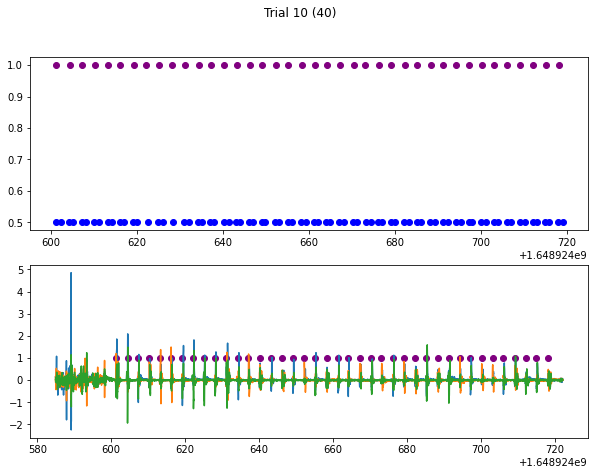

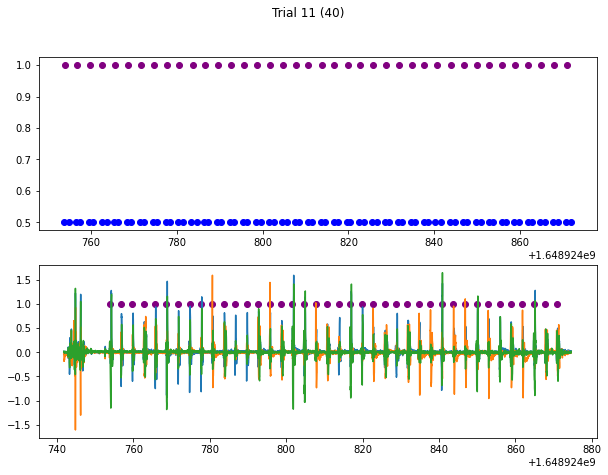

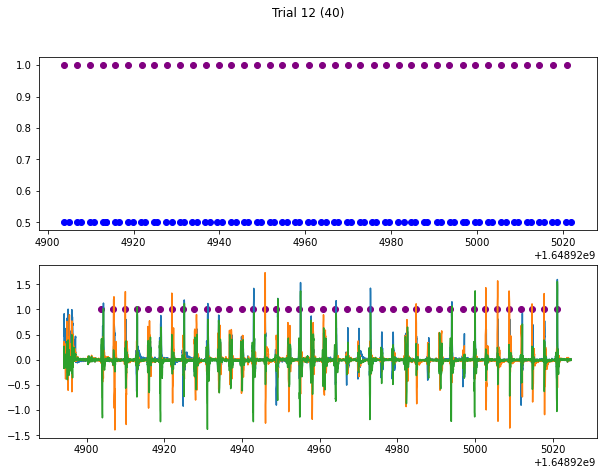

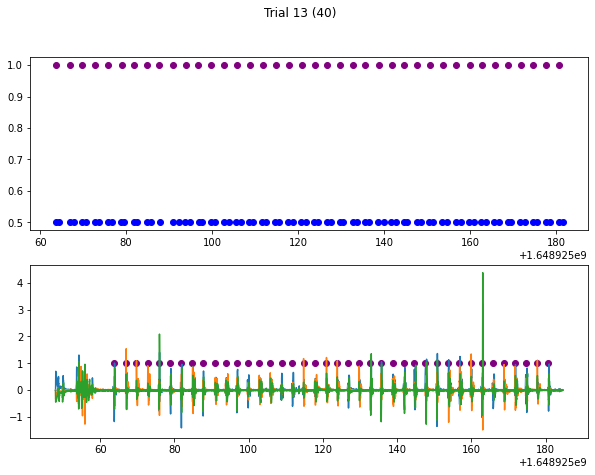

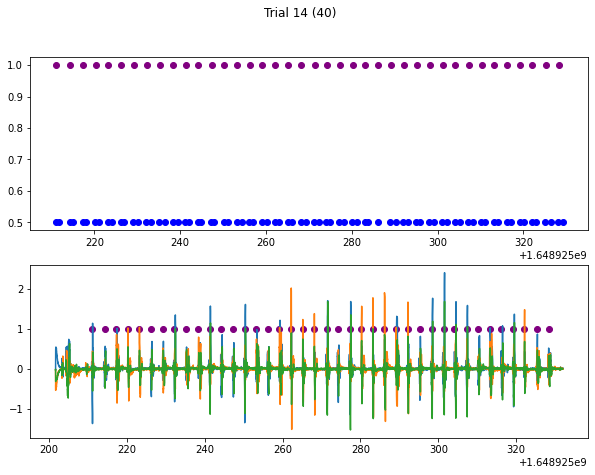

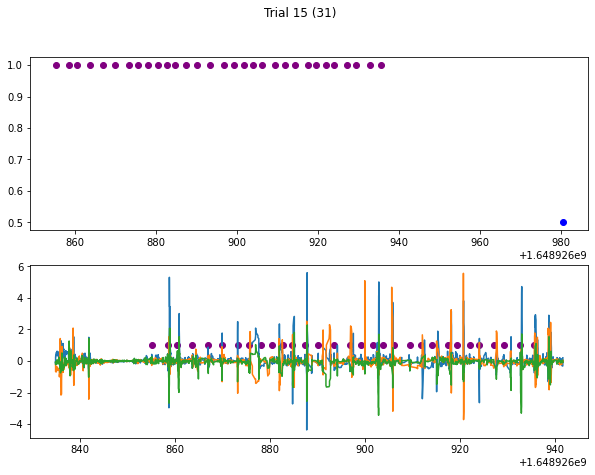

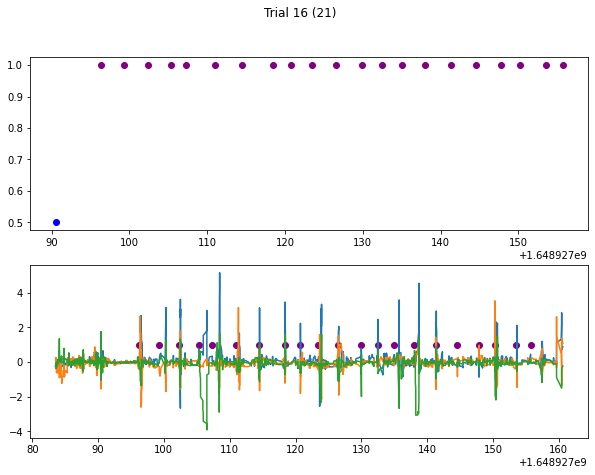

In [8]:
p_a_list = []
p_la_list = []
p_start_list = []
p_taps_list = []

for i in range(len(meta_data)):
    p_a, p_la, p_start, p_taps = parse_json(i, visualize_trace=True)
    p_a_list.append(p_a)
    p_la_list.append(p_la)
    p_start_list.append(p_start)
    p_taps_list.append(p_taps)

0.01059672751711786


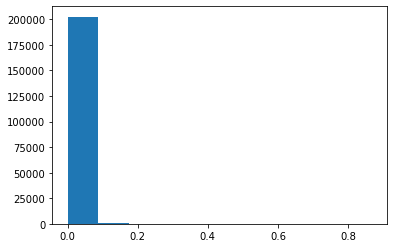

In [10]:
# figure out sampling rate
a_diffs = []
for p_a in p_a_list:
    for i in range(len(p_a["timestamps"]) - 1):
        a_diffs.append(p_a["timestamps"][i + 1] - p_a["timestamps"][i])

plt.hist(a_diffs)
print(np.mean(a_diffs))

0.010676334747233198


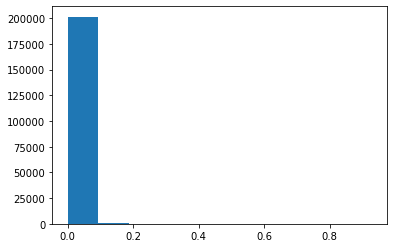

In [11]:
# figure out sampling rate
la_diffs = []
for p_la in p_la_list:
    for i in range(len(p_la["timestamps"]) - 1):
        la_diffs.append(p_la["timestamps"][i + 1] - p_la["timestamps"][i])

plt.hist(la_diffs)
print(np.mean(la_diffs))

In [12]:
2 / 0.01 # 2 seconds for each gesture

200.0

In [13]:
# taps were messy :/ -- I can probably write logic to detect them ^
for p_tap in p_taps_list:
    print(len(p_tap))

78
80
80
80
80
80
80
80
80
80
78
80
81
79
79
1
1


In [14]:
meta_data_gestures = all_meta_data_gestures[all_meta_data_gestures["trial"] < 15]
meta_data_gestures.shape

(600, 21)

In [15]:
def extract_segment(p_a, p_la, p_start, tp=100, ofs=25):
    # create segements of gestures
    # 7 measurement channels
    # 100 time points (~1 seconds) (offset 100 from crossing max)
    res = np.zeros((len(p_start["timestamps"]),
                   7,
                   tp))
    
    for i in range((len(p_start["timestamps"]))):
        # get time start of tap
        start = p_start["timestamps"][i]
        
        # get index of first valid time in p_la
        p_la_i = bisect.bisect_left(list(p_la["timestamps"]), start)
        p_la_i -= ofs
        p_la_gesture = p_la.iloc[p_la_i:p_la_i+tp, :]
        res[i][0][:] = p_la_gesture["la_x"]
        res[i][1][:] = p_la_gesture["la_y"]
        res[i][2][:] = p_la_gesture["la_z"]
        
        # get index of first valid time in p_a
        p_a_i = bisect.bisect_left(list(p_a["timestamps"]), start)
        p_a_i -= ofs
        p_a_gesture = p_a.iloc[p_a_i:p_a_i+tp, :]
        res[i][3][:] = p_a_gesture["a_1"]
        res[i][4][:] = p_a_gesture["a_2"]
        res[i][5][:] = p_a_gesture["a_3"]
        res[i][6][:] = p_a_gesture["a_4"]
    
    return res

In [16]:
# create segemented data -- ignore walking trials (too messy)
res = []
for i in range(15): 
    p_a = p_a_list[i]
    p_la = p_la_list[i]
    p_start = p_start_list[i]
    res.append(extract_segment(p_a, p_la, p_start))
    data = np.concatenate(res, axis=0)

In [17]:
data.shape

(600, 7, 100)

# Save Gestures Data + Labels

In [18]:
meta_data_gestures

,date,subject,replicate,noise-level,intent,body orientation,ring,hand,hand rest (stability),hand orientation,...,firebase,time,X_trial,X_num_taps,X_detected_starts,X_extra_starts_in_front,X_extra_starts_in_end,sanity check,trial,gesture_num
index,,,,,,,,,,,,,,,,,,,,,
0,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",...,F0442A72-0E6E-4790-AB16-00940C3D37A7.json,1:39:00 PM,0,78 (missed the first one?),42,2,0,40,0,6
1,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",...,F0442A72-0E6E-4790-AB16-00940C3D37A7.json,1:39:00 PM,0,78 (missed the first one?),42,2,0,40,0,4
2,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",...,F0442A72-0E6E-4790-AB16-00940C3D37A7.json,1:39:00 PM,0,78 (missed the first one?),42,2,0,40,0,2
3,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",...,F0442A72-0E6E-4790-AB16-00940C3D37A7.json,1:39:00 PM,0,78 (missed the first one?),42,2,0,40,0,6
4,April 2,Gati,1,clean,isolated (wrist),sitting in chair,"2-finger, pointer-index",right,no,"90 deg (in air, face-level)",...,F0442A72-0E6E-4790-AB16-00940C3D37A7.json,1:39:00 PM,0,78 (missed the first one?),42,2,0,40,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,April 2,Gati,1,clean,"large, maybe more comfortable (elbow)",sitting in chair,"2-finger, pointer-index",right,"implicitly, for comfort","-45 deg (in air, chair-level)",...,3555E195-07D5-4DBD-AC5B-68C536BB25FE.json,2:49:00 PM,14,79,42,2,0,40,14,9
596,April 2,Gati,1,clean,"large, maybe more comfortable (elbow)",sitting in chair,"2-finger, pointer-index",right,"implicitly, for comfort","-45 deg (in air, chair-level)",...,3555E195-07D5-4DBD-AC5B-68C536BB25FE.json,2:49:00 PM,14,79,42,2,0,40,14,4
597,April 2,Gati,1,clean,"large, maybe more comfortable (elbow)",sitting in chair,"2-finger, pointer-index",right,"implicitly, for comfort","-45 deg (in air, chair-level)",...,3555E195-07D5-4DBD-AC5B-68C536BB25FE.json,2:49:00 PM,14,79,42,2,0,40,14,2


In [19]:
save_data = data.reshape((data.shape[0], -1))
save_data.shape

(600, 700)

In [20]:
meta_data_gestures.to_csv("meta_gestures.csv")

In [21]:
np.savetxt("data_gestures.csv", save_data)

## Create Train Test Split

Total trials: 15
    
    * session 4 train-test-split: 80:20  
    * test: test 3 (x40 = 120)
        * trials: [2, 6, 11] (mid-height trials)
    * train: train 12 (x40 = 480)
    
 *Note:* data loader has changed (position of values in np array) since cells below were last run, so values will be different. 

In [22]:
def get_train_test_split(test_trials=[1, 4, 5]):
    """
    Split train and test but keep gestures from the same trial in the same dataset 
    """
    # subset test
    test_labels = meta_data_gestures[meta_data_gestures["trial"].isin(test_trials)][["trial", "gesture_num"]]

    # rest are train
    train_labels = meta_data_gestures[~meta_data_gestures["trial"].isin(test_trials)][["trial", "gesture_num"]]

    test_data = data[test_labels.index]
    test_labels["index"] = range(0, len(test_labels))
    test_labels = test_labels.set_index("index")

    train_data = data[train_labels.index]
    train_labels["index"] = range(0, len(train_labels))
    train_labels = train_labels.set_index("index")
    
    return train_data, train_labels, test_data, test_labels

train_data, train_labels, test_data, test_labels = get_train_test_split(test_trials=[2, 6, 11])

In [23]:
test_data.shape

(120, 7, 100)

In [24]:
train_data.shape

(480, 7, 100)

## Visualize Train Traces

In [25]:
train_labels

,trial,gesture_num
index,,
0,0,6
1,0,4
2,0,2
3,0,6
4,0,4
...,...,...
475,14,9
476,14,4
477,14,2


In [25]:
train_labels["trial"].unique()

array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 12, 13, 14])

In [26]:
def plot_trace(t_data, t_labels, choose_gesture = 1, choose_channel = 1):
    gestures = t_data[t_labels[t_labels["gesture_num"] == choose_gesture].index]
    print(gestures.shape)

    fig = plt.figure()
    ax = plt.axes()
    for i in range(gestures.shape[0]):
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])
        ax.plot(range(0, gestures.shape[2]), gestures[i][choose_channel])

(120, 6, 100)
(120, 6, 100)
(120, 6, 100)
(120, 6, 100)


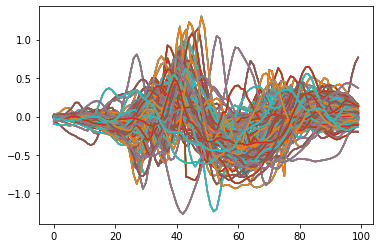

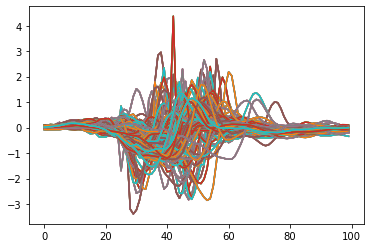

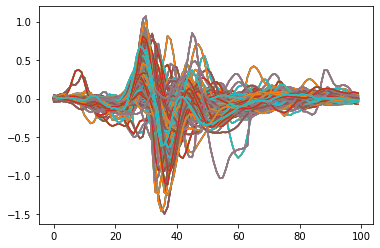

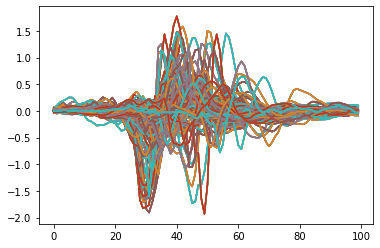

In [27]:
# train data for gesture
plot_trace(train_data, train_labels, choose_gesture = 6, choose_channel = 5)
plot_trace(train_data, train_labels, choose_gesture = 4, choose_channel = 5)
plot_trace(train_data, train_labels, choose_gesture = 2, choose_channel = 5)
plot_trace(train_data, train_labels, choose_gesture = 9, choose_channel = 5)

# Apply PCA and SVM

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [35]:
def run_pipeline(x_train, x_test, y_train, y_test, n_comp=0, 
                 show_confusion=True, show_pca_gesture=True, show_pca_trial=True):
    # Fit to data and predict gesture
    if n_comp == 0:
        n_pc = x_train.shape[0] - 5
    else:
        n_pc = n_comp
    clf = make_pipeline(StandardScaler(), PCA(n_components=n_pc), SVC())
    clf.fit(x_train, y_train["gesture_num"])
    pred_test = clf.predict(x_test)
    acc = accuracy_score(y_test["gesture_num"], pred_test)
    
    if (show_confusion):
        # print accuracy
        print("Prediction accuracy for test dataset")
        print(f"{acc:.2%}")

        # visualize confusion matrirx
        cm = confusion_matrix(y_test["gesture_num"], pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot()
        plt.show()

        # visualize pca
        scaler = clf.named_steps["standardscaler"]
        x_train_proj = scaler.transform(x_train)
        pca = clf.named_steps["pca"]
        x_train_proj = pca.transform(x_train_proj)

    if (show_pca_gesture):
        # plot train gesture
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        scatter = ax.scatter(
                x=x_train_proj[:, 0],
                y=x_train_proj[:, 1],
                c=y_train["gesture_num"],
                cmap="tab20",
            )
        # produce a legend with the unique colors from the scatter
        legend = ax.legend(*scatter.legend_elements(prop="colors"),
                            loc="lower left", title="Gestures")
        ax.add_artist(legend)

    if (show_pca_trial):
        # plot train trial
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        scatter = ax.scatter(
                x=x_train_proj[:, 0],
                y=x_train_proj[:, 1],
                c=y_train["trial"],
                cmap="tab20c",
            )
        # produce a legend with the unique colors from the scatter
        legend = ax.legend(*scatter.legend_elements(prop="colors"),
                            loc="lower left", title="Trials")
        ax.add_artist(legend)
        print("train trials", y_train["trial"].unique())
        
    return acc

(480, 600)
(120, 600)
Prediction accuracy for test dataset
67.50%


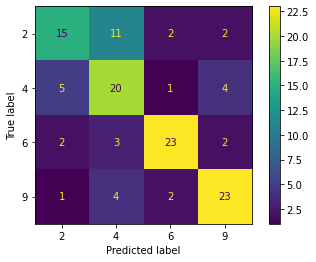

train trials [ 0  1  3  4  5  7  8  9 10 12 13 14]


0.675

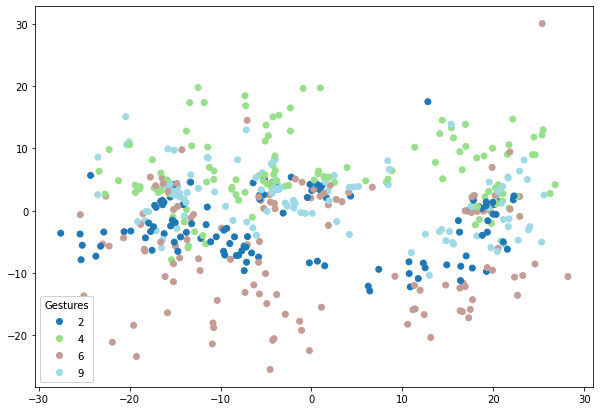

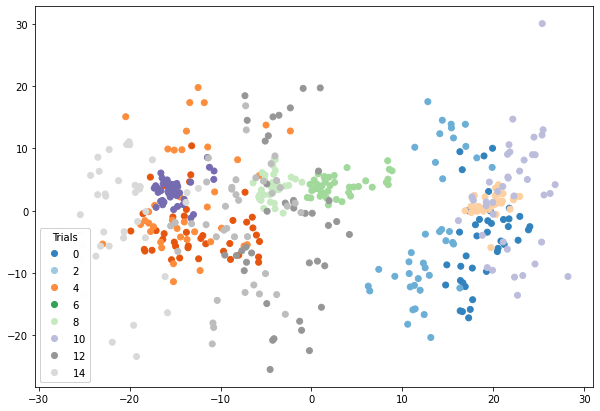

In [36]:
# reshape data to be gestures x ?
# max accuracy --> 26%
x_train = train_data.reshape(train_data.shape[0], -1)
print(x_train.shape)

x_test = test_data.reshape(test_data.shape[0], -1)
print(x_test.shape)

run_pipeline(x_train, x_test, train_labels, test_labels, n_comp=70)

(480, 300)
(120, 300)
Prediction accuracy for test dataset
64.17%


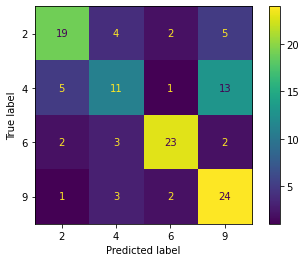

train trials [ 0  1  3  4  5  7  8  9 10 12 13 14]


0.6416666666666667

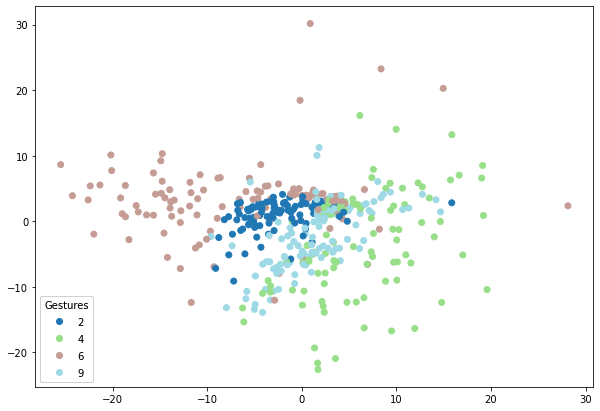

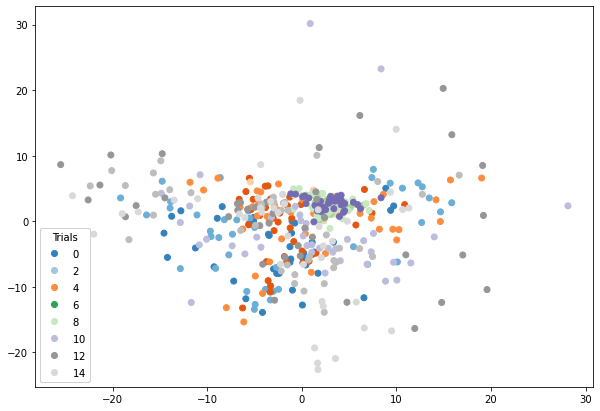

In [37]:
# reshape data to be gestures x ?, only use linear acceleration
# max accuracy --> 14%
x_train = train_data[:, 3:6, :].reshape(train_data.shape[0], -1)
print(x_train.shape)

x_test = test_data[:, 3:6, :].reshape(test_data.shape[0], -1)
print(x_test.shape)

run_pipeline(x_train, x_test, train_labels, test_labels, n_comp=70)

## BUG: color scheme is strange for trials-colored PCA plot

## Cross Validate Chosen Feature Set
* A set of 4 gestures was chosen because they appeared most commonly in the good feature set (distinguishable in test set at 83% with PCA + SVD) and themselves created a good feature set
    * 2 (swipe right)
    * 4 (swipe down)
    * 6 (counter bottom)
    * 9 (tap)
* The test set was comprised of 3 representative trials (12 gestures instances total):
    * 1 (45 deg, in air, chest-level)
    * 4 (0 deg, in air, thigh-level)
    * 5 (0 deg, on surface, thigh-level)
* Train set was comprised of remaining 6 trials (24 gesture instances total)

*With Cross Validation*: check if [2, 4, 6, 9] feature set is robustly good across other test trials

In [38]:
import itertools

In [39]:
def run_pipeline_on_gesture_list(train_data, train_labels, test_data, test_labels,
                                 gesture_list = [2, 4, 6, 9],
                                 show_confusion=False, show_pca_gesture=False, show_pca_trial=False):
    # choose gestures
    train_labels_chosen_gestures = train_labels[train_labels["gesture_num"].isin(gesture_list)]
    train_data_chosen_gestures = train_data[train_labels_chosen_gestures.index]
    train_labels_chosen_gestures

    test_labels_chosen_gestures = test_labels[test_labels["gesture_num"].isin(gesture_list)]
    test_data_chosen_gestures = test_data[test_labels_chosen_gestures.index]
    test_labels_chosen_gestures

    # reshape data to be gestures x ?
    # max accuracy --> 50%
    x_train = train_data_chosen_gestures.reshape(train_data_chosen_gestures.shape[0], -1)
    print(x_train.shape)

    x_test = test_data_chosen_gestures.reshape(test_data_chosen_gestures.shape[0], -1)
    print(x_test.shape)

    acc = run_pipeline(x_train, x_test, train_labels_chosen_gestures, test_labels_chosen_gestures, 
                       show_confusion=show_confusion, show_pca_gesture=show_pca_gesture, show_pca_trial=show_pca_trial)
    return acc

(480, 600)
(120, 600)
Prediction accuracy for test dataset
69.17%


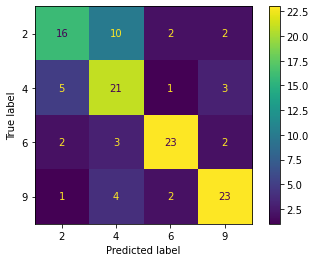

train trials [ 0  1  3  4  5  7  8  9 10 12 13 14]


0.6916666666666667

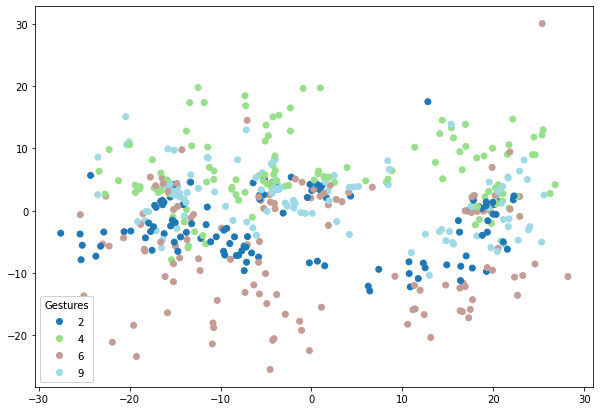

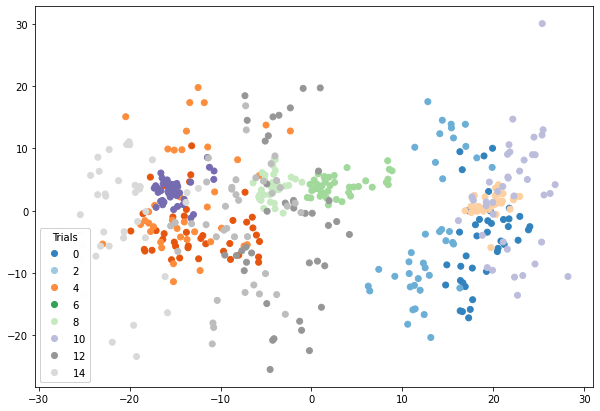

In [40]:
run_pipeline_on_gesture_list(train_data, train_labels, test_data, test_labels, 
                             gesture_list = [2, 4, 6, 9],
                             show_confusion=True, show_pca_gesture=True, show_pca_trial=True)

In [43]:
gesture_list = [2, 4, 6, 9]
comb_test_trials = list(itertools.combinations(range(0, 15), 3))
cross_val_acc = []
for ta, tb, tc in comb_test_trials:
    train_data, train_labels, test_data, test_labels = get_train_test_split(test_trials=[ta, tb, tc])
    print(train_data.shape, test_data.shape)
    print(len(train_labels), len(test_labels))
    acc = run_pipeline_on_gesture_list(train_data, train_labels, test_data, test_labels,
                                      gesture_list=gesture_list)
    cross_val_acc.append(acc)
    
df_cross_val = pd.DataFrame({
    "a": [a for a, b, c in comb_test_trials],
    "b": [b for a, b, c in comb_test_trials],
    "c": [c for a, b, c in comb_test_trials],
    "cross_val_acc": cross_val_acc 
})

(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) 

(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) 

(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) 

(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) (120, 6, 100)
480 120
(480, 600)
(120, 600)
(480, 6, 100) 

In [44]:
df_cross_val.sort_values("cross_val_acc")

,a,b,c,cross_val_acc
399,7,8,9,0.250000
371,6,7,8,0.250000
335,5,6,7,0.258333
343,5,7,8,0.283333
372,6,7,9,0.300000
...,...,...,...,...
233,2,12,14,0.933333
100,1,2,12,0.933333
22,0,2,12,0.933333
24,0,2,14,0.941667


89.89010989010988 of cross-val combs have greater than 50% acc


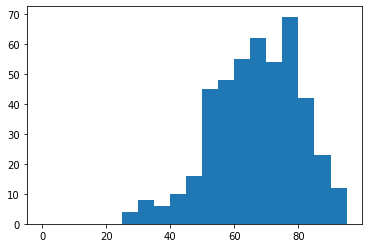

In [69]:
df_cross_val["cross_val_acc_percent"] = df_cross_val['cross_val_acc'].apply(lambda x: x * 100)
plt.hist(df_cross_val["cross_val_acc_percent"], bins=range(0, 100, 5))
print(100 * df_cross_val[df_cross_val["cross_val_acc"] > .5].shape[0] / df_cross_val.shape[0], "of cross-val combs have greater than 50% acc")

In [53]:
df_cross_val[df_cross_val["cross_val_acc"] > .5].shape

(409, 5)

In [48]:
df_cross_val[df_cross_val["cross_val_acc"] > .8].shape

(71, 5)

In [49]:
df_cross_val[df_cross_val["cross_val_acc"] > .9].shape

(12, 5)

Unsurprisingly, the small, very discrete gestures are the hard tests. (trials 5-9)

(array([ 1.,  0.,  1.,  3.,  7., 26., 17., 19., 17., 20., 14., 20.,  1.,
         4.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <BarContainer object of 14 artists>)

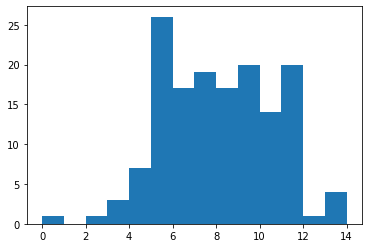

In [65]:
hard_tests = df_cross_val.sort_values("cross_val_acc").head(50)
plt.hist(list(hard_tests["a"]) + list(hard_tests["b"]) + list(hard_tests["c"]), bins=range(0, 15))

The wrist motions (trials 0-4) and some of the lower height elbow motions (10-14) are generalizable
* trials 10, 11 (head-height, chest-height) were strange, but that might just be Gati's weirdness when doing them

(array([17., 21., 29., 12.,  6.,  0.,  5.,  4.,  0.,  0.,  5.,  0., 21.,
        30.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <BarContainer object of 14 artists>)

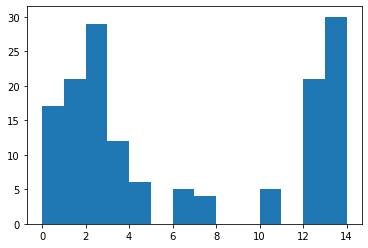

In [66]:
easy_tests = df_cross_val.sort_values("cross_val_acc").tail(50)
plt.hist(list(easy_tests["a"]) + list(easy_tests["b"]) + list(easy_tests["c"]), bins=range(0, 15))